# Lesson 5: Leveraging Assistants API for SQL Databases

## Setup

In [1]:
from openai import AzureOpenAI
import json
import os

## Import the helper function

To access the ``Helper.py`` file, please go to the ``File`` menu and select ``Open...``.

In [2]:
import Helper
from Helper import get_positive_cases_for_state_on_date
from Helper import get_hospitalized_increase_for_state_on_date

## Launch the Assistant API

**Note**: The pre-configured cloud resource grants you access to the Azure OpenAI GPT model. The key and endpoint provided below are intended for teaching purposes only. Your notebook environment is already set up with the necessary keys, which may differ from those used by the instructor during the filming.

In [3]:
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-15-preview",
    azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
    )

# I) Create assistant
assistant = client.beta.assistants.create(
  instructions="""You are an assistant answering questions 
                  about a Covid dataset.""",
  model="gpt-4-1106", 
  tools=Helper.tools_sql)

# II) Create thread
thread = client.beta.threads.create()
print(thread)

Thread(id='thread_YG3yWIYatMVL4HyHAUqW41ef', created_at=1724309241, metadata={}, object='thread')


In [4]:
# III) Add message
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""how many hospitalized people we had in Alaska
               the 2021-03-05?"""
)
print(message)

ThreadMessage(id='msg_tBgV4PwwuySK9Nwoagi2Nv9H', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='how many hospitalized people we had in Alaska\n               the 2021-03-05?'), type='text')], created_at=1724309241, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_YG3yWIYatMVL4HyHAUqW41ef')


In [5]:
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_tBgV4PwwuySK9Nwoagi2Nv9H",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "how many hospitalized people we had in Alaska\n               the 2021-03-05?"
          },
          "type": "text"
        }
      ],
      "created_at": 1724309241,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "thread_id": "thread_YG3yWIYatMVL4HyHAUqW41ef"
    }
  ],
  "object": "list",
  "first_id": "msg_tBgV4PwwuySK9Nwoagi2Nv9H",
  "last_id": "msg_tBgV4PwwuySK9Nwoagi2Nv9H",
  "has_more": false
}


In [6]:
# IV) Run assistant on thread

run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
)

## Leverage the function calling with Assistants API

In [7]:
import time
from IPython.display import clear_output

start_time = time.time()

status = run.status

while status not in ["completed", "cancelled", "expired", "failed"]:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,run_id=run.id
    )
    print("Elapsed time: {} minutes {} seconds".format(
        int((time.time() - start_time) // 60),
        int((time.time() - start_time) % 60))
         )
    status = run.status
    print(f'Status: {status}')
    if (status=="requires_action"):
        available_functions = {
            "get_positive_cases_for_state_on_date": get_positive_cases_for_state_on_date,
            "get_hospitalized_increase_for_state_on_date":get_hospitalized_increase_for_state_on_date
        }

        tool_outputs = []
        for tool_call in run.required_action.submit_tool_outputs.tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            function_response = function_to_call(
                state_abbr=function_args.get("state_abbr"),
                specific_date=function_args.get("specific_date"),
            )
            print(function_response)
            print(tool_call.id)
            tool_outputs.append(
                { "tool_call_id": tool_call.id,
                 "output": str(function_response)
                }
            )

        run = client.beta.threads.runs.submit_tool_outputs(
          thread_id=thread.id,
          run_id=run.id,
          tool_outputs = tool_outputs
        )


messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages)

Elapsed time: 0 minutes 5 seconds
Status: requires_action
{'date': '2021-03-05', 'hospitalizedIncrease': 3}
call_uk7lx4ZKRH3VBbjZgWgZUUSD
Elapsed time: 0 minutes 10 seconds
Status: completed
SyncCursorPage[ThreadMessage](data=[ThreadMessage(id='msg_LByGX4EBscCypuFyc3LQRrRg', assistant_id='asst_DrYI3KM3iIn6hetpe7Dzy0Sf', content=[MessageContentText(text=Text(annotations=[], value='On March 5, 2021, Alaska reported an increase of 3 hospitalizations due to COVID-19.'), type='text')], created_at=1724309249, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_8tsuMRBTh8ju00qt5XEeAHLO', thread_id='thread_YG3yWIYatMVL4HyHAUqW41ef'), ThreadMessage(id='msg_tBgV4PwwuySK9Nwoagi2Nv9H', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='how many hospitalized people we had in Alaska\n               the 2021-03-05?'), type='text')], created_at=1724309241, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='t

In [8]:
print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_LByGX4EBscCypuFyc3LQRrRg",
      "assistant_id": "asst_DrYI3KM3iIn6hetpe7Dzy0Sf",
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "On March 5, 2021, Alaska reported an increase of 3 hospitalizations due to COVID-19."
          },
          "type": "text"
        }
      ],
      "created_at": 1724309249,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "run_8tsuMRBTh8ju00qt5XEeAHLO",
      "thread_id": "thread_YG3yWIYatMVL4HyHAUqW41ef"
    },
    {
      "id": "msg_tBgV4PwwuySK9Nwoagi2Nv9H",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "how many hospitalized people we had in Alaska\n               the 2021-03-05?"
          },
          "type": "text"
        }
      ],
      "created_at": 1724309241,
      "file_ids": [],
      "metadata": {},

## Add the code interpreter

In [9]:
file = client.files.create(
  file=open("./data/all-states-history.csv", "rb"),
  purpose='assistants'
)
assistant = client.beta.assistants.create(
  instructions="""You are an assitant answering questions about
                  a Covid dataset.""",
  model="gpt-4-1106", 
  tools=[{"type": "code_interpreter"}],
  file_ids=[file.id])
thread = client.beta.threads.create()
print(thread)
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="""how many hospitalized people we had in Alaska
               the 2021-03-05?"""
)
print(message)
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id,
)

Thread(id='thread_sFWW6oMyaltrwVHC6J7g9UWw', created_at=1724309256, metadata={}, object='thread')
ThreadMessage(id='msg_mrmmqLAUGwt6JeZVR9GjW2jK', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='how many hospitalized people we had in Alaska\n               the 2021-03-05?'), type='text')], created_at=1724309256, file_ids=[], metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_sFWW6oMyaltrwVHC6J7g9UWw')


In [10]:
status = run.status
start_time = time.time()
while status not in ["completed", "cancelled", "expired", "failed"]:
    time.sleep(5)
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    print("Elapsed time: {} minutes {} seconds".format(
        int((time.time() - start_time) // 60),
        int((time.time() - start_time) % 60))
         )
    status = run.status
    print(f'Status: {status}')
    clear_output(wait=True)


messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_dXckyTvkJiWPnepfIytrpGmx",
      "assistant_id": "asst_t1Gm6xBDfHKsALgicH9hKvKD",
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "On March 5, 2021, there were 33 people hospitalized due to COVID-19 in Alaska."
          },
          "type": "text"
        }
      ],
      "created_at": 1724309269,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "run_akrEu5GpG861khRsMrwcakXf",
      "thread_id": "thread_sFWW6oMyaltrwVHC6J7g9UWw"
    },
    {
      "id": "msg_mrmmqLAUGwt6JeZVR9GjW2jK",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "how many hospitalized people we had in Alaska\n               the 2021-03-05?"
          },
          "type": "text"
        }
      ],
      "created_at": 1724309256,
      "file_ids": [],
      "metadata": {},
     

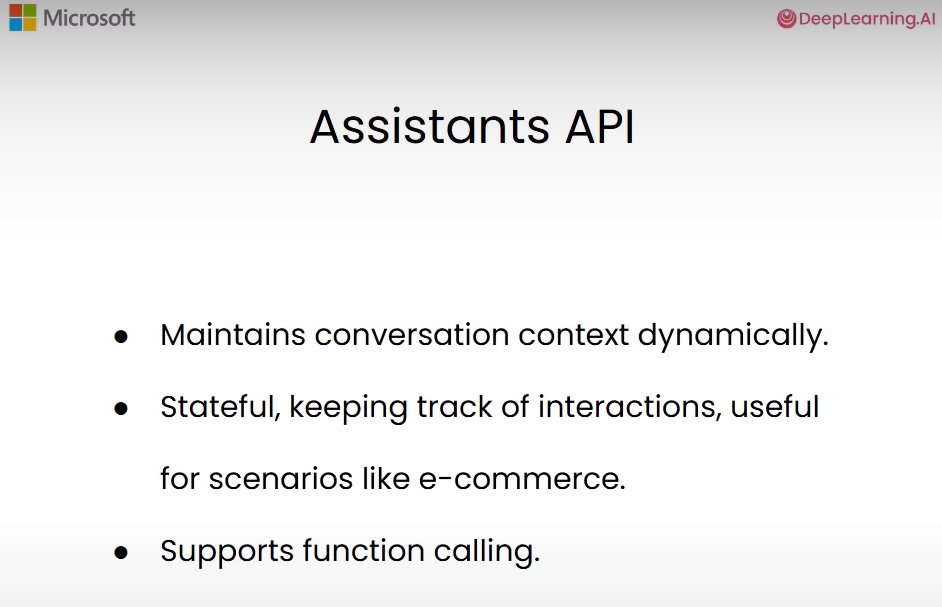

The assistants API is different because it maintains the context
of the discussion dynamically.
Unlike chat completions, which are stateless.
The assistants API is a stateful, meaning that it keeps track of the conversation.
This is useful for scenarios like e-commerce,
where maintaining context across interaction is important.
Within the assistants API, we can also
use function calling.

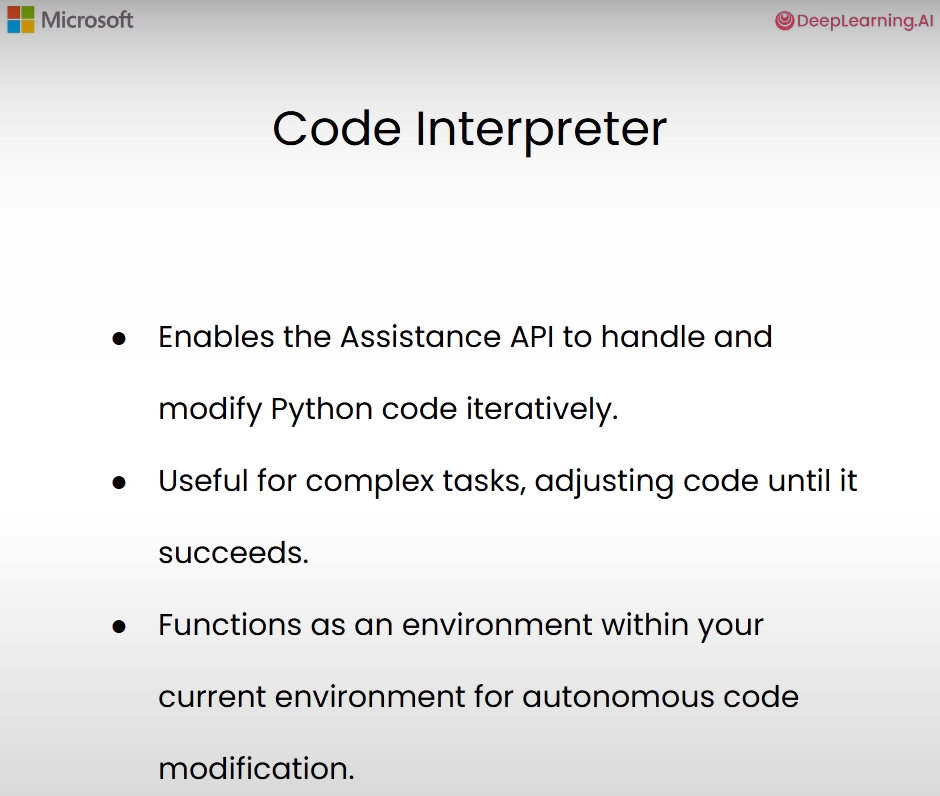

The code interpreter feature
allows the assistants API to handle Python code.
t can run code iteratively, modifying it
until the execution succeeds, which is very useful for complex tasks.
The code interpreter feature
s like an environment within your current environment,
enabling the agent to modify its own code to find solutions.
This lesson will help you explore the stateful capabilities of the assistants
API and the code interpreter for dynamic and complex interactions.